# CNN on CIFAR-10


CIFAR-10 dataset contains 32x32 color images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week3/images/cifar10.jpg?raw=1" style="width:80%">

# Import stuff

In [0]:
import sys
sys.path.append("..")
#import download_utils

In [0]:
download_utils.link_all_keras_resources()

In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#import keras_utils

# Load dataset

In [4]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 19s 0us/step


In [5]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [0]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

Let's show just a couple of randon images from a dataset here.

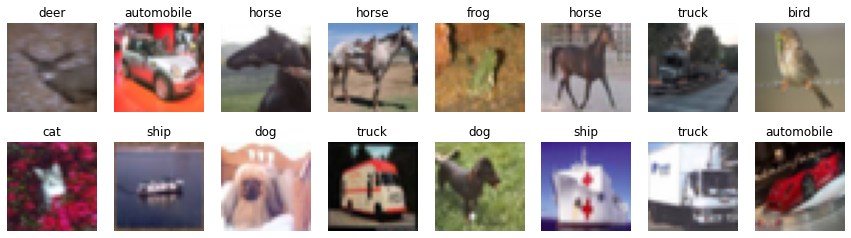

In [7]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

In [0]:
# normalization
x_train2 = x_train/255.-0.5
x_test2 = x_test/255. - 0.5

# one-hot encoded
y_train2 = tf.keras.utils.to_categorical(y_train, 10)
y_test2 = tf.keras.utils.to_categorical(y_test, 10)

# CNN architecture

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.layers import LeakyReLU, InputLayer

Layers used:

- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - performs convolution.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - performs 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - flattens the input, does not affect the batch size.
- [Dense](https://keras.io/layers/core/#dense) - fully-connected layer.
- [Activation](https://keras.io/layers/core/#activation) - applies an activation function.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - applies leaky relu activation.
- [Dropout](https://keras.io/layers/core/#dropout) - applies dropout.

In [0]:
def make_model():

    model = Sequential()
    
    model.add(InputLayer([32, 32, 3]))
    
    model.add(Conv2D(16, [3, 3], padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, [3, 3], padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D([2, 2]))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, [3, 3], padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, [3, 3], padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D([2, 2]))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, ))
    model.add(Dropout(0.5))
    model.add(LeakyReLU(0.1))
    
    model.add(Dense(NUM_CLASSES, ))
    model.add(Activation('softmax'))
  
    return model

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9

# Train model

In [0]:
INIT_LR = 5e-3  
BATCH_SIZE = 32
EPOCHS = 10

model = make_model() 

model.compile(
    loss='categorical_crossentropy', 
    optimizer = tf.keras.optimizers.Adamax(learning_rate=INIT_LR), 
    metrics=['accuracy'],  
)


def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

In [0]:
# callback for printing of actual learning rate used by optimizer
class LrHistory(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

Training takes approximately **1.5 hours**. You're aiming for ~0.80 validation accuracy.

In [0]:
# model checkpoints 
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None

#### to continue training from model checkpoint
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 7
# model = load_model(model_filename.format(last_finished_epoch))

In [0]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):

  def on_train_batch_end(self, batch, logs=None):
    if batch%100==0:
      print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))

  def on_test_batch_end(self, batch, logs=None):
    if batch%100==0:
      print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))

  def on_epoch_end(self, epoch, logs=None):
    print('\t\t\t The average loss for epoch {} is {:7.2f}.'.format(epoch, logs['loss']))


In [18]:
# fit model
model.fit(
    x_train2, y_train2,  
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[LossAndErrorPrintingCallback()],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

For batch 0, loss is    2.30.
For batch 100, loss is    2.10.
For batch 200, loss is    1.93.
For batch 300, loss is    1.82.
For batch 400, loss is    1.76.
For batch 500, loss is    1.70.
For batch 600, loss is    1.65.
For batch 700, loss is    1.61.
For batch 800, loss is    1.58.
For batch 900, loss is    1.55.
For batch 1000, loss is    1.51.
For batch 1100, loss is    1.49.
For batch 1200, loss is    1.46.
For batch 1300, loss is    1.44.
For batch 1400, loss is    1.42.
For batch 1500, loss is    1.40.
For batch 0, loss is    0.66.
For batch 100, loss is    0.99.
For batch 200, loss is    0.99.
For batch 300, loss is    0.99.
			 The average loss for epoch 0 is    1.38.
For batch 0, loss is    1.11.
For batch 100, loss is    1.02.
For batch 200, loss is    1.03.
For batch 300, loss is    1.02.
For batch 400, loss is    1.01.
For batch 500, loss is    1.01.
For batch 600, loss is    1.00.
For batch 700, loss is    1.00.
For batch 800, loss is    1.00.
For batch 900, loss is    0

# Evaluating model

In [0]:
y_pred_test = model.predict(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

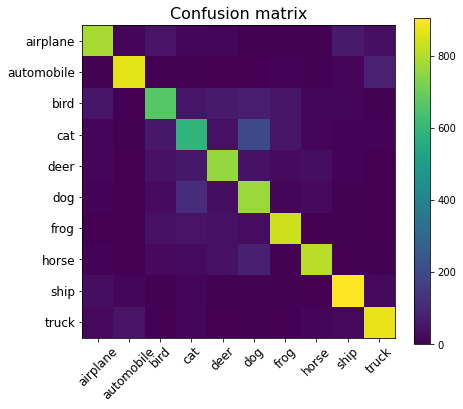

Test accuracy: 0.7862


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score


plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

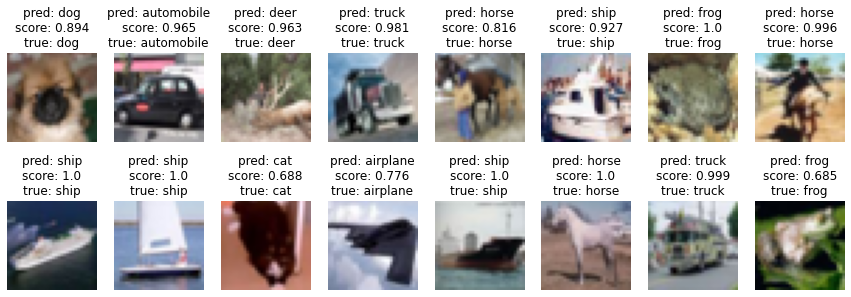

In [22]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

As I honestly sometimes can't distinguish what is what, and time spent on training is short, this score is quite not bad.